<a href="https://colab.research.google.com/github/iamemc/PD_02/blob/main/PD_03_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining / Prospecção de Dados

## Diogo F. Soares and Sara C. Madeira, 2020/21

# Project 2 - Clustering

## Logistics 

**_Read Carefully_**

**Students should work in teams of 2 or 3 people**. 

Individual projects might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `April, 18th (23:59)`.** 

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the zip file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202021_P2.ipynb`as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs** (File > Download as > HTML).

**Decisions should be justified and results should be critically discussed.** 

_Project solutions containing only code and outputs without discussions will achieve a maximum grade 10 out of 20._

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/)**.

The dataset to be analysed is **`medulloblastoma_genes.csv`**. It includes 76 samples of medulloblastoma (MB) with respective expression levels of 54.675 genes measured in children with ages between 3 and 16 years. Medulloblastoma is a malignant childhood brain tumour comprising four discrete subgroups. 

In this project you will consider the labels of the samples included in the `labels.csv` file where samples are labelled as MB-CL or Other. In this case, we have 51 samples of classic medulloblastoma (MB-CL) and 25 other types (namely: 6 desmoplastic nodular, 17 anaplastic and 2 medullomyoblastoma).

In `medulloblastoma_genes.csv` each line represents a sample and each column represents a gene.


**The goal is to cluster samples and (ideally) find "MB-CL" groups and "Other MB" groups.** 

## Team Identification

**GROUP NNN**

Students:

* **Eduardo Carvalho - nº55881**
* **Filipe Santos - nº55142**
* **Ivo Oliveira - nº50301**

## 1. Load and Preprocess Dataset

At the end of this step you should have:
* a 76 rows × 54675 columns matrix, **X**, containing the values of the 54675 features for each of the 76 samples.
* a vector, **y**, with the 76 type of medulloblastoma, which you can use later to evaluate clustering quality.

In [55]:
# Importing relevant libraries
from pandas import read_csv, DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix

In [56]:
X=read_csv('/content/medulloblastoma_genes.csv', index_col=0)
X.shape

(76, 54675)

In [57]:
y=read_csv('/content/labels.csv', index_col=0)
y.shape

(76, 1)

In [58]:
# X, y = df.iloc[:, 1:].values, df2.iloc[:, 1].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                      test_size=0.3, 
#                      random_state=0, 
#                      stratify=y)

## 2. Dimensionality Reduction

As you already noticed the number of features (genes) is extremely high when compared to the number of objects to cluster (samples). In this context, you should perform dimensionality reduction, that is, reduce the number of features, in two ways:

* [**Removing features with low variance**](http://scikit-learn.org/stable/modules/feature_selection.html)

* [**Using Principal Component Analysis**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

At the end of this step you should have two new matrices with the same number of rows, each with a different number of columns (features): **X_variance** and **X_PCA**. 

**Don't change X you will need it!**

### Low variance

In [59]:
var_thresh = VarianceThreshold(threshold=0)
var_X = var_thresh.fit_transform(X)

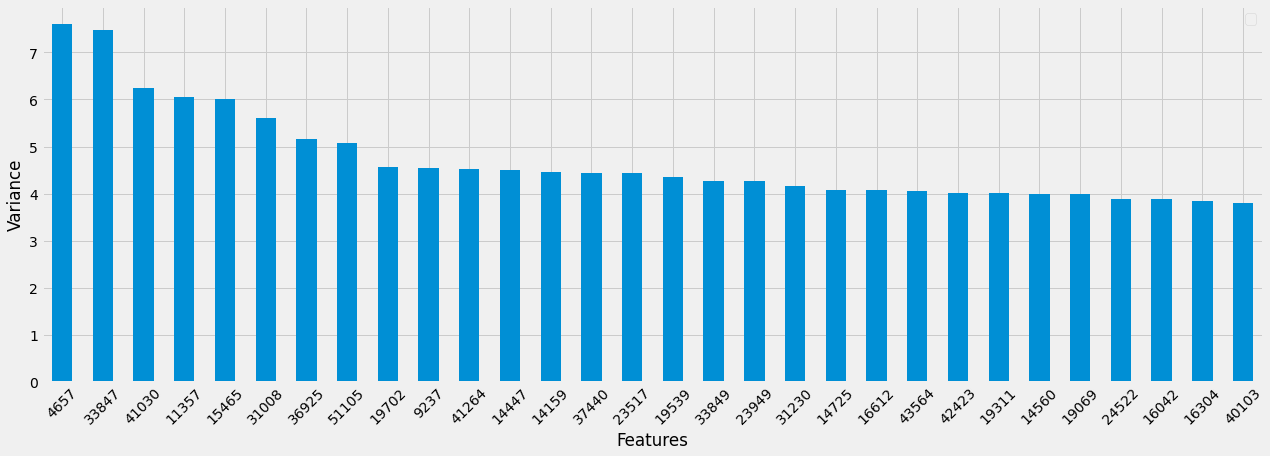

In [60]:
df_var=DataFrame(var_thresh.variances_, columns=['Variance'])\
                .sort_values(by='Variance', ascending=False)
df_var.head(30).plot.bar()
plt.xlabel('Features')
plt.ylabel('Variance');
plt.legend('')
plt.tight_layout()
plt.gcf().set_size_inches(20, 8)
plt.xticks(rotation = 45)
plt.show()

> By looking at the plot, we can identify the first 5 values as a good cutoff, as these features should a considerably higher variance than the rest.

In [61]:
df_var.head(10)

,Variance
4657,7.595610
33847,7.466448
41030,6.239501
11357,6.046499
15465,6.008597
31008,5.602876
36925,5.170070
51105,5.065053
19702,4.564589
9237,4.551036


> The threshold for the variance, to keep the 5 highest values, seems to be 6. We can now create a new VarianceThreshold object with this information.

In [62]:
new_vt = VarianceThreshold(threshold=6)
new_vt.fit_transform(X)
mask=new_vt.get_support()
X_variance=X.loc[:, mask]
X_variance.head(3)

,1559213_at,201909_at,206018_at,224588_at,231776_at
GSM918578,9.81713,9.16842,6.28339,6.72311,10.39320
GSM918579,9.95981,8.47725,6.09289,3.71113,11.33250
GSM918580,4.89110,4.91192,3.27714,8.43272,6.44556


> Variance is influenced by the scale of the values. We can try to standardize the values, by dividing them for each feature's mean, and see if the results are significantly different.

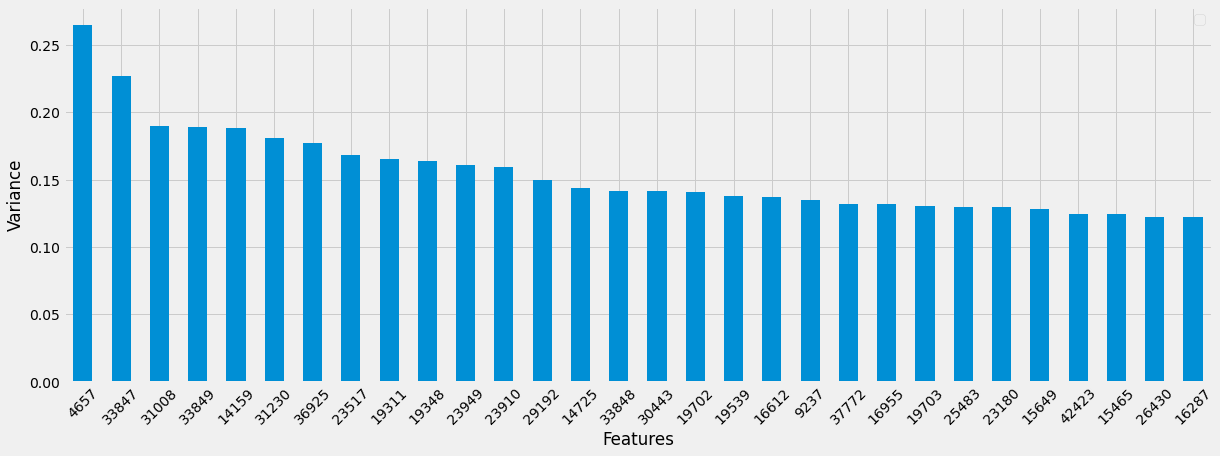

In [63]:
X_means = X / X.mean()
var_thresh_2 = VarianceThreshold(threshold=0)
var_X_2 = var_thresh_2.fit_transform(X_means)
df_var_2=DataFrame(var_thresh_2.variances_, columns=['Variance'])\
                .sort_values(by='Variance', ascending=False)
                
df_var_2.head(30).plot.bar()
plt.xlabel('Features')
plt.ylabel('Variance');
plt.legend('')
plt.tight_layout()
plt.gcf().set_size_inches(20, 8)
plt.xticks(rotation = 45)
plt.show()

> The results appear to be the same. The most obvious cutoff point is 2, with 5 being the next. So, we can continue with the previous selection. 

### PCA

In [64]:
# Standardizing the features
std_X = StandardScaler().fit_transform(X)
std_X[:2]

array([[ 0.43813081, -0.75440001,  0.32568064, ...,  2.87953397,
         1.42154643,  0.28421232],
       [ 0.89052271, -0.61551373,  0.96802109, ..., -0.59352407,
         0.82974694,  3.0380959 ]])

In [65]:
pca = PCA()
df_pca = DataFrame(pca.fit_transform(std_X))
df_pca.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,12.340287,-39.854200,87.506092,-13.945923,69.587501,16.000048,-69.751186,-97.542748,-18.555197,23.202332,38.101135,6.849776,-80.736914,3.615623,-52.215574,-5.427141,-2.616986,-16.314621,-14.317895,-27.948922,12.546979,-43.412513,-29.591780,-6.664107,22.220410,44.528407,-5.382747,62.636074,17.965380,73.957244,-34.257248,20.044997,29.572688,-39.561024,-22.76223,17.263921,6.239143,7.080457,30.696294,-27.246912,-16.765437,21.334005,-15.920084,-3.115480,4.532650,8.864375,-1.119921,-12.042777,-1.815172,-1.710648,5.702976,-8.542566,8.883464,4.606239,-4.798239,-1.770272,7.718174,-2.395592,4.161583,10.065773,1.067186,7.287068,2.267765,0.738914,-0.728984,2.457625,3.645871,6.331097,3.822609,-8.734254,-3.039607,-2.785044,-0.359489,2.726267,4.081747,3.777073e-14
1,173.847859,10.413431,10.600977,-38.641559,-17.448066,39.665034,-45.909995,23.765517,31.818684,-23.984644,10.409079,3.062235,-14.431139,-7.336351,8.896721,-38.133037,-24.286519,89.972125,55.364609,-62.677230,-25.182659,37.538972,13.691064,106.497689,34.140422,20.068512,-59.221168,-6.284531,-29.575560,8.767018,-16.611558,-17.892528,-25.582799,3.365256,-3.81785,8.824096,-6.344005,-8.371824,17.157103,3.882657,-19.713154,-19.118000,-15.261608,-1.121523,2.642513,0.179401,11.145235,0.380007,-5.079097,14.300394,2.688002,0.064441,-8.066140,-3.610300,-2.756124,-8.738837,8.978711,-0.947571,2.984235,-5.703362,-2.676381,-0.020045,0.924820,-0.563433,-0.510048,7.447425,1.142829,1.780735,3.415738,-0.388306,0.934785,5.139709,-3.364719,4.336945,0.486843,3.777073e-14
2,126.637826,200.152167,-4.041612,18.350663,38.805693,46.166046,-91.388758,62.506372,5.104203,0.763372,-2.088847,-29.386360,-3.173918,14.506452,-31.188315,-72.332699,-26.115821,-35.829264,69.892602,69.243809,-95.078754,-47.403200,-23.090247,-39.882672,13.941420,0.837892,21.763163,-8.939288,-10.150046,4.255702,16.505935,-4.613358,2.804056,-2.191240,6.19637,1.863909,-22.659582,3.698271,-6.941626,-0.015839,7.946977,9.866795,6.962022,0.793480,7.355684,-3.614569,0.809775,-18.280916,4.933513,-1.552109,1.294216,4.964785,3.980324,4.073673,3.757684,2.358018,3.002453,0.945488,-4.274169,-6.283289,-3.973626,-0.639468,1.372114,-3.485046,-0.410319,3.789142,-0.485412,2.426564,0.709291,1.583861,-3.028894,-2.191085,3.079382,-4.228800,1.708837,3.777073e-14


In [66]:
#DataFrame(pca.explained_variance_ratio_).head(30).plot.bar()
#plt.legend('')
#plt.tight_layout()
#plt.gcf().set_size_inches(10, 4)
#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance');


> Looking at the top 30 components in terms of explained variance, we can see some considerable drops at 3 points: from the 2nd to the 3rd, from the 3rd to the 4th and from the 6th to the 7th. Afterwards, the drop in explained variance is less noticeable.
>
> We will choose to keep 3 principal components as this number allows for easier comprehension of the dataset while still keeping a high amount of information.

In [67]:
pca = PCA(n_components=3)
pca.fit(std_X)
X_PCA = pca.transform(std_X)
X_PCA[:3]

array([[ 12.34037507, -39.85467233,  87.49448063],
       [173.84797765,  10.41386821,  10.60894698],
       [126.63791975, 200.15262456,  -4.03912835]])

## 3. Clustering Samples using Partitional Clustering

Use **`K`-means** to cluster the samples:

* Cluster the original data (54.675 features): **X**.
    * Use different values of `K`.
    * For each value of `K` present the clustering by specifying how many samples MB-CL and Other are in each cluster.     
    For instance, `{0: {'MB-CL': 51, 'Other': 0}, 1: {'MB-CL': 0, 'Other': 25}}` is the ideal clustering that we aimed at obtained with K-means when `K=2`, where the first cluster has 51 MB-CL samples and 0 Other samples and the second cluster has 0 MB-CL samples and 25 Other samples.
    You can choose how to output this information.  **Tip**: You can explore the usage of contigency matrices.
    * What is the best value of `K` ? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data obtained after removing features with low variance: **X_variance**.
    * Study different values of `K` as above.

* Cluster the data obtained after applying PCA: **X_PCA**.
    * Study different values of `K` as above.

* Compare the results obtained in the three datasets above for the best `K`. 
* Discuss the results.

## K-means - X

In [68]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans.fit(std_X) #using standardized data
kmeans.cluster_centers_

array([[-0.03457972, -0.24572179, -0.27972979, ...,  0.07987952,
        -0.10067716, -0.07679438],
       [ 0.0328064 ,  0.23312067,  0.26538467, ..., -0.07578313,
         0.09551423,  0.07285621]])

In [69]:
kmeans.labels_

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

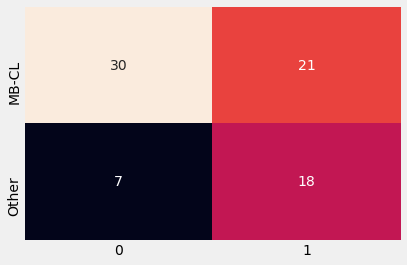

In [70]:
cm_X=contingency_matrix(y['class'], kmeans.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.show()
#most_bought.fig.set_figheight(12.5)
#most_bought.fig.set_figwidth(25)

> In this case we have 30 MB-CL samples in cluster 0 and 21 in cluster 1. We also have 7 "Other" samples in cluster 0 and 18 in cluster 1. The samples do not appear to be correctly separated according to the true labels.

### Determining ideal number of clusters by Elbow Plot

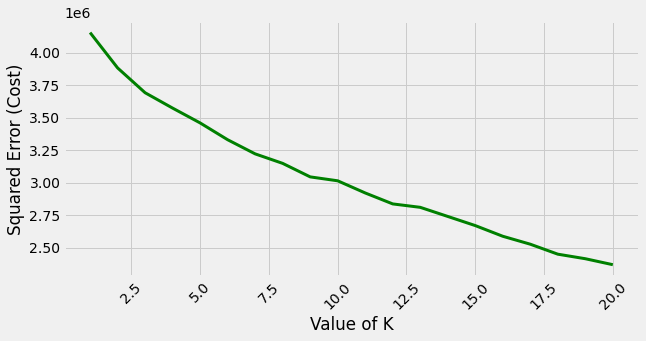

In [71]:
cost =[]
for i in range(1, 21):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(std_X)
      
    # calculates squared error for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show() 

> Using the method of Elbow Plot does not seem to be very helpful, as there is no discernible cutoff point that we can use

### Determining ideal number of clusters by Silhouette Score

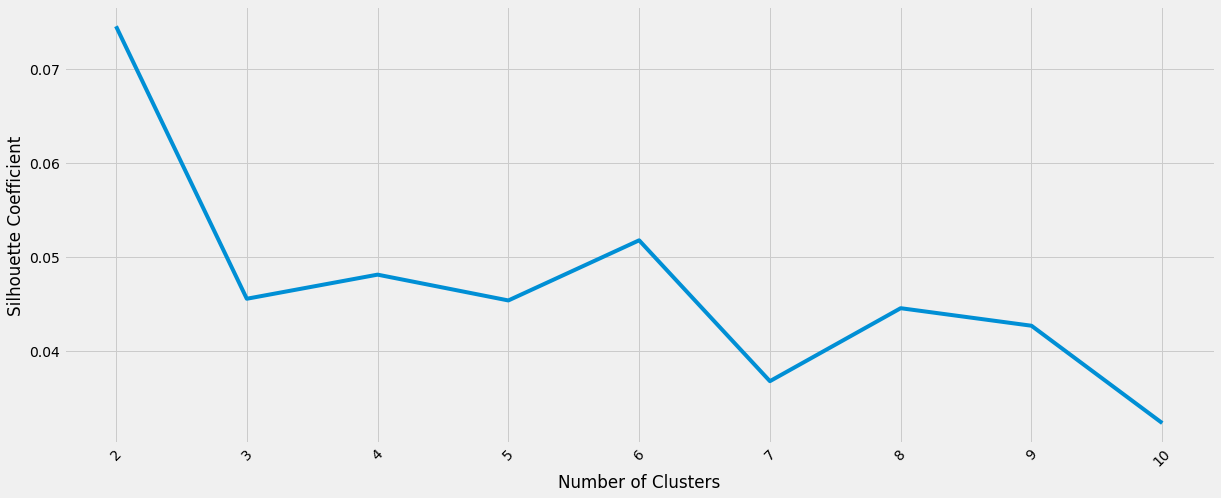

In [72]:
silhouette_coefficients = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(std_X)
  score = silhouette_score(std_X, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(20, 8)
plt.xticks(rotation = 45)
plt.show()

> The best number of clusters seems to be 2 as it has the highest value for the silhouette coefficient. In this case, we won't have to run the algorithm again, as we already used k=2 in the previous run.

### Running k-means for different values of k


n_cluster = 2



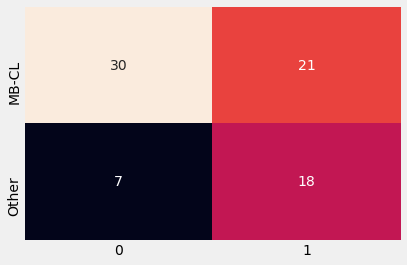


n_cluster = 3



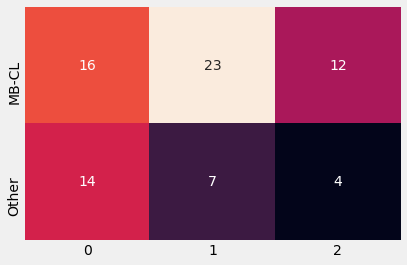


n_cluster = 4



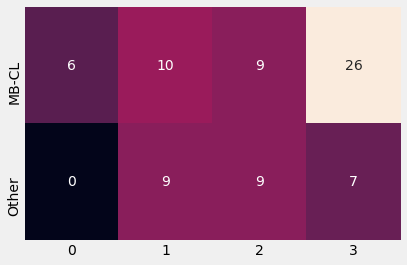


n_cluster = 5



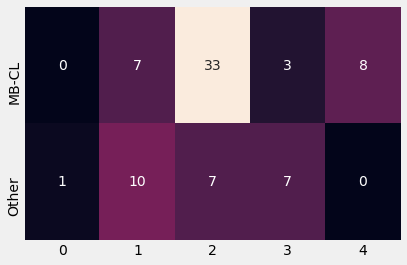


n_cluster = 6



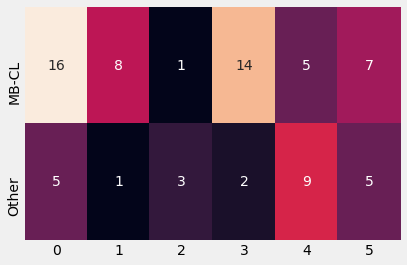


n_cluster = 7



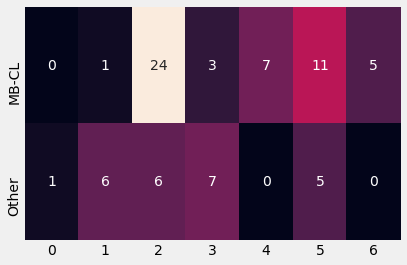


n_cluster = 8



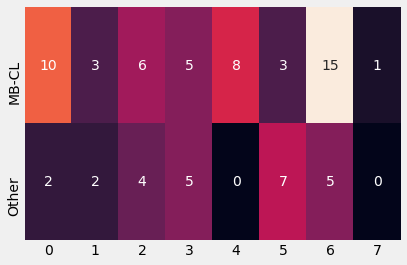


n_cluster = 9



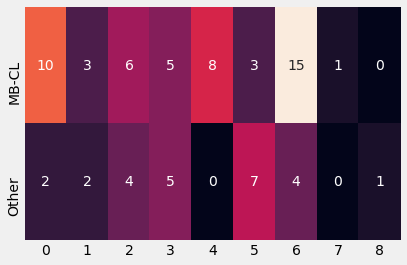


n_cluster = 10



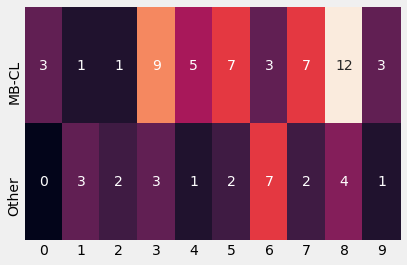

In [73]:
for i in range(2,11):
  print('\nn_cluster = ' + str(i) + '\n')
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans = kmeans.fit(std_X)
  cm_X=contingency_matrix(y['class'], kmeans.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

> Looking at the contingency matrices for k between 2 and 10, we can see that, for k=4 and k=5, there are clusters where the predominant label is 'MB-CL' (cluster 3 for k=4, cluster 2 for k=5).
>
> Between these two, k=5 seems to be the case where this distinction is more evident, as the remaining clusters together don't have near as many 'MB-CL' labels as cluster 2 (18 vs 33).
>
> There isn't a k value where a cluster is predominantly composed of the label 'Other'.

> Based on the silhouette score and the contingency matrices, we conclude that, for the dataset with all features and standardized values, the ideal number of clusters is 2 - the silhouette score is the highest and there is an acceptable separation between labels.

## K-means - X_variance

In [74]:
# Standardizing the features
std_X_var = StandardScaler().fit_transform(X_variance)

# K-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans.fit(std_X_var)
kmeans.cluster_centers_

array([[-0.41087861, -1.47003462, -0.47378004,  1.45709028, -0.2873122 ],
       [ 0.16739499,  0.598903  ,  0.1930215 , -0.59362937,  0.11705312]])

In [75]:
kmeans.labels_

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

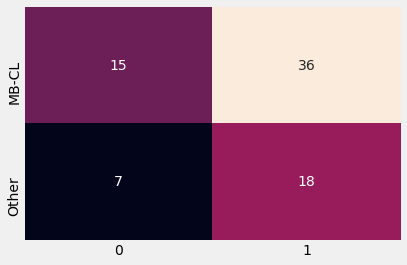

In [76]:
cm_X_var=contingency_matrix(y['class'], kmeans.labels_)
sn.heatmap(cm_X_var, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.show()

> In this case we have 15 MB-CL samples in cluster 0 and 36 in cluster 1. We also have 7 "Other" samples in cluster 0 and 18 in cluster 1. Again, the samples do not appear to be correctly separated according to the true labels as both clusters appear to have a ratio of 2:1 in terms of labels (with predominance for label 'MB-CL', in both cases).

### Determining ideal number of clusters by Elbow Plot

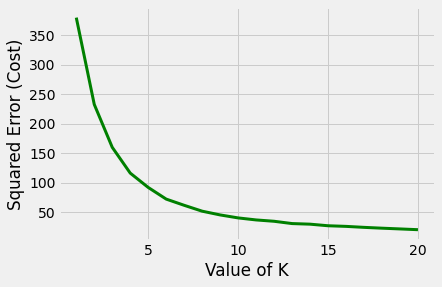

In [77]:
cost =[]
for i in range(1, 21):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(std_X_var)
      
    # calculates squared error for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() 

> This time we can actually spot an elbow shape in the plot, with the ideal value for k being between 4 and 6 (where the plot starts to stabilize).

### Determining ideal number of clusters by Silhouette Score

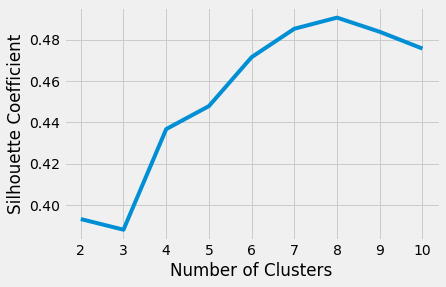

In [78]:
silhouette_coefficients = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(std_X_var)
  score = silhouette_score(std_X_var, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

> The highest values for the silhouette coefficient are for k=10, 9 and. K=6 also shows a high score and it also matches with the observations made in elbow plot, appearing to be the most likely candidate thus far.

### Running k-means for different values of k


n_cluster = 2



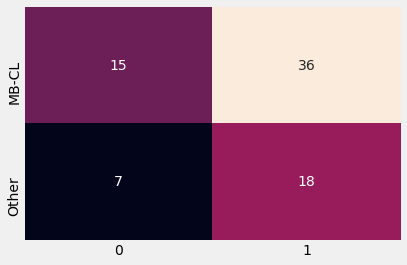


n_cluster = 3



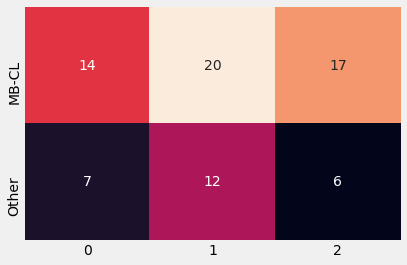


n_cluster = 4



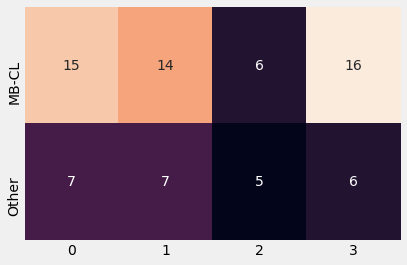


n_cluster = 5



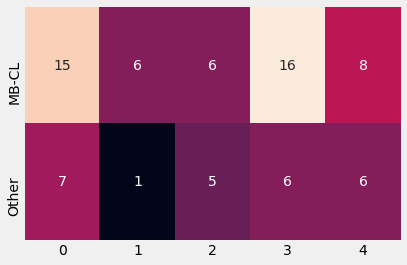


n_cluster = 6



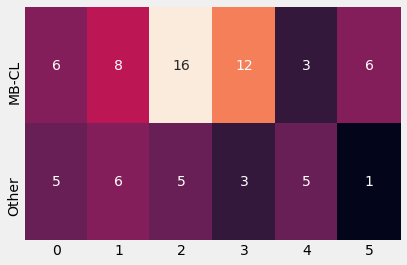


n_cluster = 7



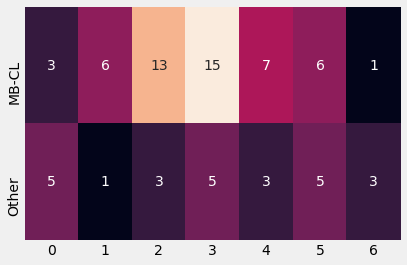


n_cluster = 8



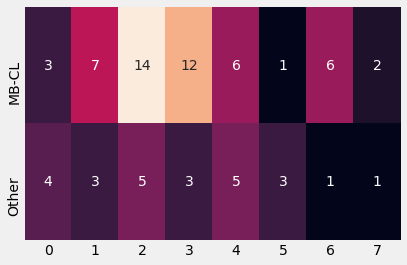


n_cluster = 9



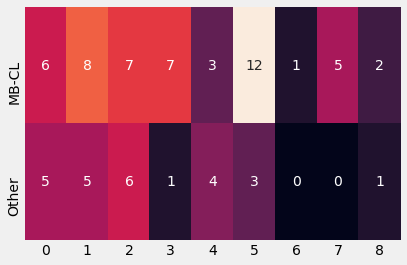


n_cluster = 10



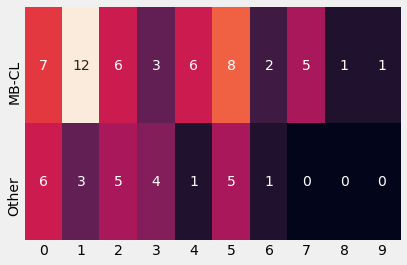

In [79]:
for i in range(2,11):
  print('\nn_cluster = ' + str(i) + '\n')
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans = kmeans.fit(std_X_var)
  cm_X=contingency_matrix(y['class'], kmeans.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

> There isn't really a k value where the the separation between labels is clear but k=6, as we have seen before, has two clusters with mostly 'MB-CL' labels. K=5 also shows the same level of separation.
>
> Again, there is no cluster where the label 'Other' is clearly predominant.

> Based on the silhouette score and the contingency matrices, we conclude that, for the dataset with only the high variance features and standardized values, the ideal number of clusters is 6 - the silhouette score is very high, the elbow plot starts to stabilize from that point forward and there is an acceptable separation between labels.

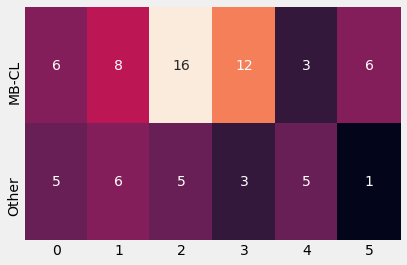

In [80]:
# K-means
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans = kmeans.fit(std_X_var)

# continency matrix
cm_X_var=contingency_matrix(y['class'], kmeans.labels_)
sn.heatmap(cm_X_var, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.show()

## K-means - X_PCA

In [81]:
# Standardizing the features
std_X_PCA = StandardScaler().fit_transform(X_PCA)

# K-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans.fit(std_X_PCA)
kmeans.cluster_centers_

array([[-0.43454904,  1.20896109,  0.35505079],
       [ 0.20056109, -0.55798204, -0.1638696 ]])

In [82]:
kmeans.labels_

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

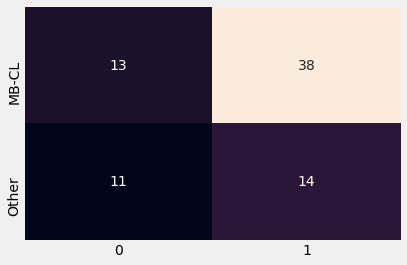

In [83]:
cm_X_PCA=contingency_matrix(y['class'], kmeans.labels_)
sn.heatmap(cm_X_PCA, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.show()

> We have 13 MB-CL samples in cluster 0 and 38 in cluster 1. There is a higher level of separation here than on the cases we have seen before. We also have 11 "Other" samples in cluster 0 and 14 in cluster 1. The samples for 'Other' still do not appear to be correctly separated according to the true labels.

### Determining ideal number of clusters by Elbow Plot

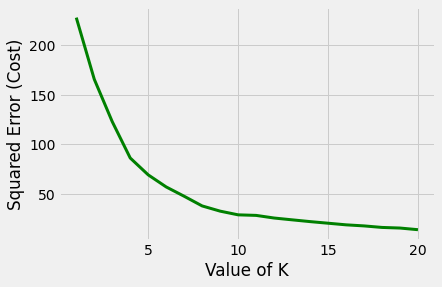

In [84]:
cost =[]
for i in range(1, 21):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(std_X_PCA)
      
    # calculates squared error for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() 

> Like in the previous case, there is a noticeable elbow shape situated between k=4 and k=8. The ideal number of clusters should be somewhere between that interval.

### Determining ideal number of clusters by Silhouette Score

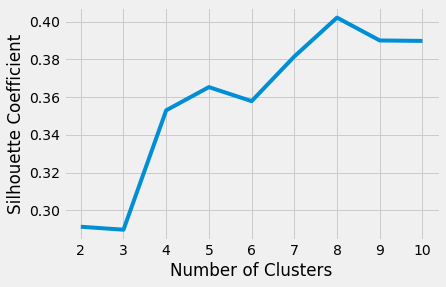

In [85]:
silhouette_coefficients = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(std_X_PCA)
  score = silhouette_score(std_X_PCA, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

> The silhouette coefficient is higher for k values between 8 and 10 (9 being the highest). However, there is a considerable increase in the score for k=4, a value that is inside the interval determined by the elbow plot.
>
> For these reasons, k=4 seems to be the primary candidate for the number of clusters.

### Running k-means for different values of k


n_cluster = 2



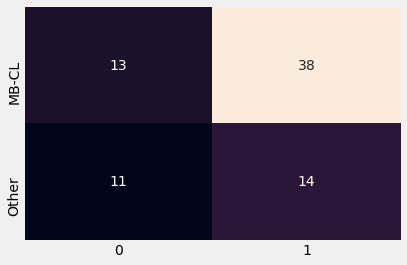


n_cluster = 3



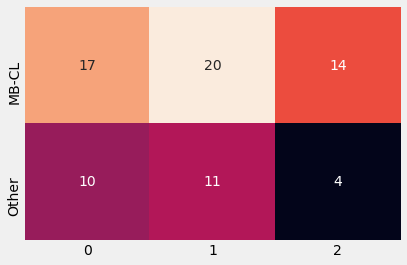


n_cluster = 4



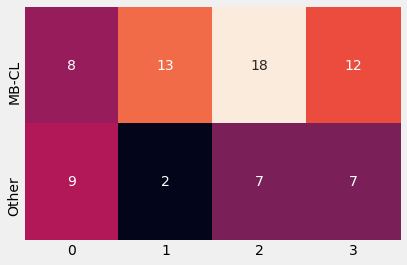


n_cluster = 5



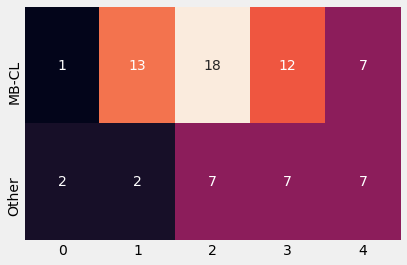


n_cluster = 6



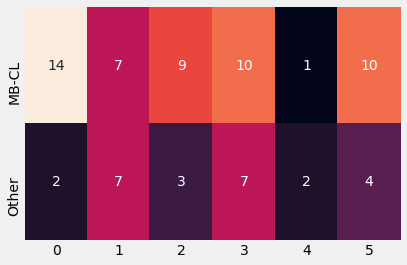


n_cluster = 7



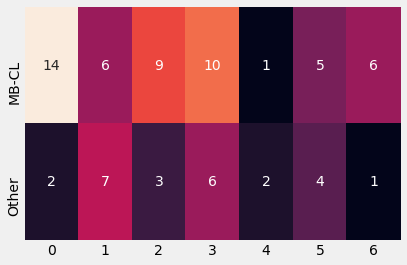


n_cluster = 8



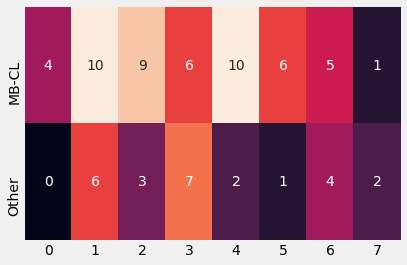


n_cluster = 9



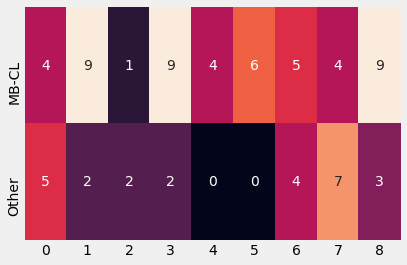


n_cluster = 10



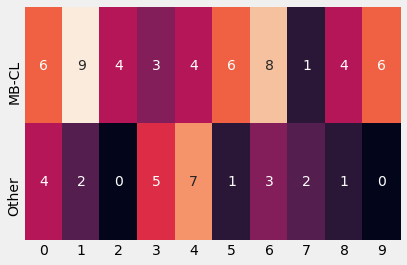

In [86]:
for i in range(2,11):
  print('\nn_cluster = ' + str(i) + '\n')
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans = kmeans.fit(std_X_PCA)
  cm_X=contingency_matrix(y['class'], kmeans.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

> Looking at the contingency matrices for k between 2 and 10, we can see that, for k=4 there are 2 clusters where the predominant label is 'MB-CL' (cluster 1 and 2), whereas for for k=5 there are 3 (clusters 1, 2 and 3).
>
> This seems to corroborate the previous assertion that k=4 is the best value for k, for the dataset after PCA.
>
> Again, there isn't a k value for which a cluster is predominantly composed of the label 'Other'.

> Based on the silhouette score, contingency matrices and elbow plot, we conclude that, for the dataset after PCA and standardized values, the ideal number of clusters is 4 - its silhouette score displays a big increase, the elbow plot seems to stabilize around that region and there is an acceptable separation between labels.

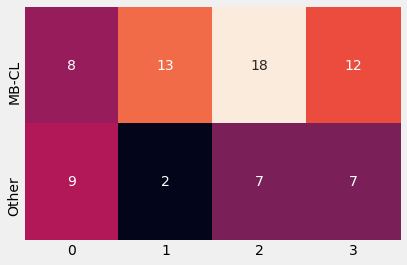

In [87]:
# K-means
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans = kmeans.fit(std_X_PCA)

# continency matrix
cm_X_PCA=contingency_matrix(y['class'], kmeans.labels_)
sn.heatmap(cm_X_PCA, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.show()

## Comparison of Results and Discussion

## 4. Clustering Samples using Hierarchical Clustering

Use a **Hierarchical Clustering Algorithm (HCA)** to cluster the samples: 

* Cluster the data in **X_variance**.
    * Use **different linkage metrics**.
    * Use different values of `K`.
    * For each linkage metric and value of `K` present the clustering by specifying how many MB-CL and Other samples are in each cluster as you did before. 
    * What is the best linkage metric and the best value of `K`? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data in **X_PCA**.
    * Study different linkage metrics and different values of `K` as above.

* Compare the results obtained in the two datasets above for the best linkage metric and the best `K`. 
* Discuss the results

# Different linkage metrics for k=2


linkage_metric = average



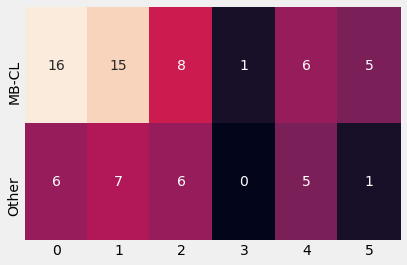


linkage_metric = ward



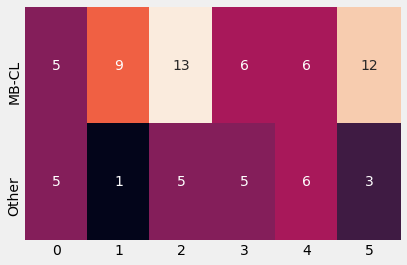


linkage_metric = complete



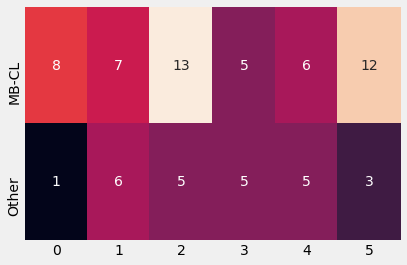


linkage_metric = single



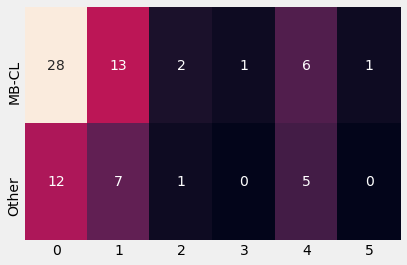

In [88]:
from sklearn.cluster import AgglomerativeClustering

#linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
#‘ward’ minimizes the variance of the clusters being merged.
#‘average’ uses the average of the distances of each observation of the two sets.
#‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
#‘single’ uses the minimum of the distances between all observations of the two sets.

std_X_var = StandardScaler().fit_transform(X_variance)
std_X_PCA = StandardScaler().fit_transform(X_PCA)


#hca = AgglomerativeClustering(linkage ="average", n_clusters=2)
# Grow the cluster hierarchy until K = 2 (dendogram)
#hca = hca.fit(std_X_var)
# Cluster memmberships
#hca.labels_
#cm_X_var1=contingency_matrix(y['class'], hca.labels_)
#sn.heatmap(cm_X_var1, annot=True, cmap="rocket", cbar=False, 
#           yticklabels=['MB-CL','Other'])
#plt.show()

linkage= ["average","ward","complete","single"]
for i in linkage:
  print('\nlinkage_metric = ' + str(i) + '\n')
  hca = AgglomerativeClustering(linkage =i, n_clusters=6)
  hca = hca.fit(std_X_var)
  cm_X=contingency_matrix(y['class'], hca.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

# Silhoutte score for various linkages


linkage_metric = average



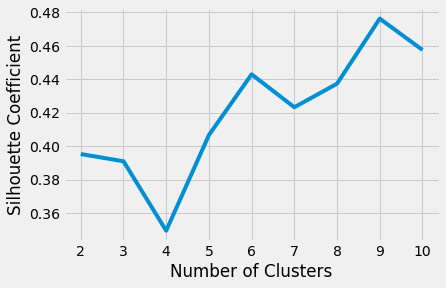


linkage_metric = ward



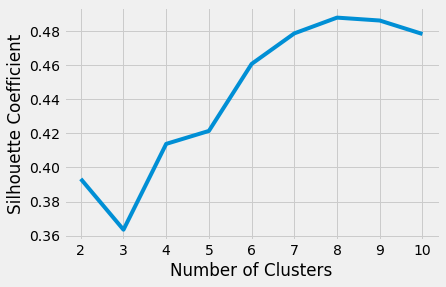


linkage_metric = complete



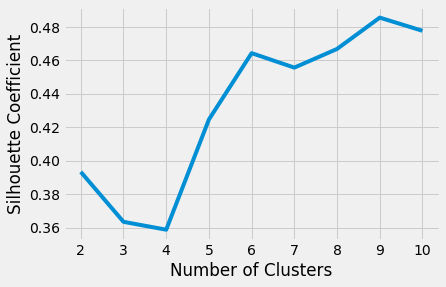


linkage_metric = single



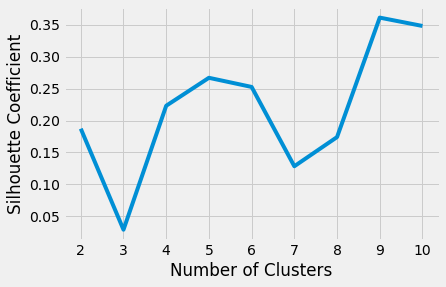

In [89]:
linkage= ["average","ward","complete","single"]
for j in linkage:
  print('\nlinkage_metric = ' + str(j) + '\n') 
  silhouette_coefficients = []
  for i in range(2, 11):
    hca = AgglomerativeClustering(linkage =j, n_clusters=i)
    hca = hca.fit(std_X_var)
    score = silhouette_score(std_X_var, hca.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, 11), silhouette_coefficients)
  plt.xticks(range(2, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

## 5. Evaluating Clustering Results

#best k for linkage "ward"

#best k for linkage "ward"


n_cluster = 2



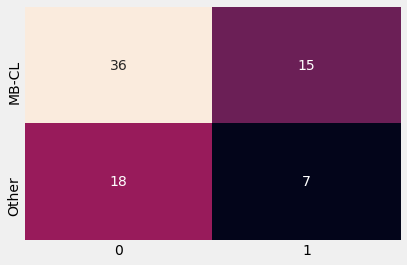


n_cluster = 3



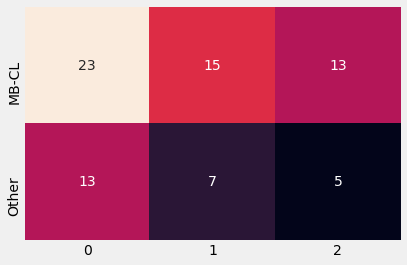


n_cluster = 4



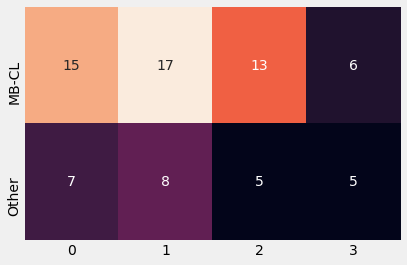


n_cluster = 5



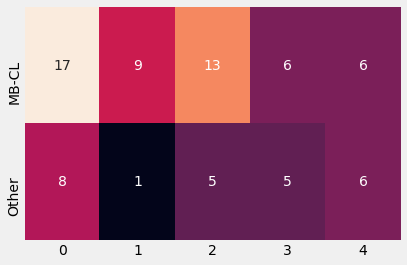


n_cluster = 6



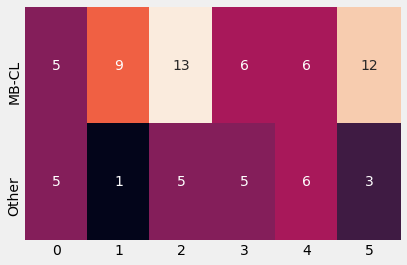


n_cluster = 7



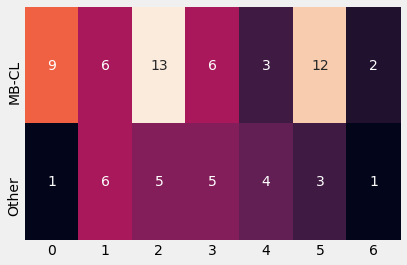


n_cluster = 8



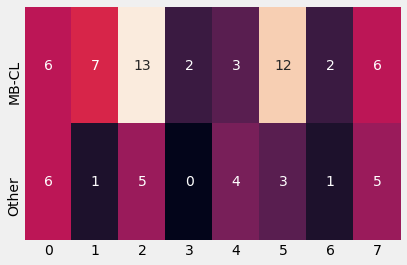


n_cluster = 9



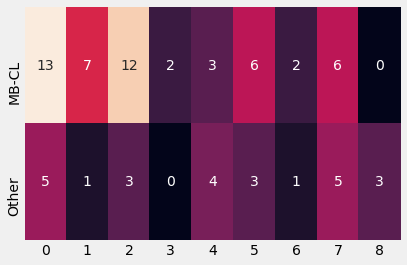


n_cluster = 10



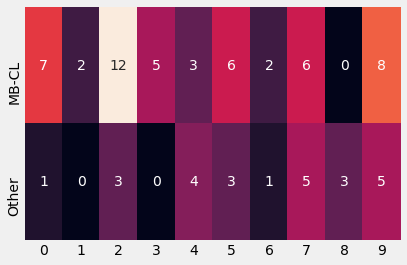

In [90]:
for i in range(2,11):
  print('\nn_cluster = ' + str(i) + '\n')
  hca = AgglomerativeClustering(linkage ="ward", n_clusters=i)
  hca = hca.fit(std_X_var)
  cm_X=contingency_matrix(y['class'], hca.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

In this task you should compare the best results obtained using `K`-means and HCA 
1. **Without using ground truth**
2. **Using ground truth (`Medulloblastoma Type`)**.

### 5.1. Without Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

In [91]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


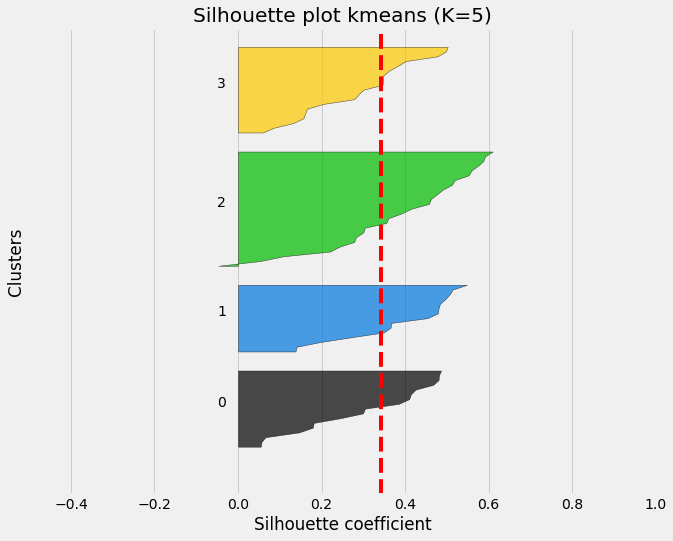

In [92]:
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.cm as cm
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

X_PCA

#drawSillouette(X, kmeans.labels_, "kmeans (K=5)")
drawSillouette(X_PCA, kmeans.labels_, "kmeans (K=5)")

EXPLAIN HERE

In [93]:
from sklearn.metrics.cluster import calinski_harabasz_score

print("Kmeans Calinski Harabasz score is:", calinski_harabasz_score(X, kmeans.labels_))
print("   HAC Calinski Harabasz score is:", calinski_harabasz_score(X, hca.labels_))

Kmeans Calinski Harabasz score is: 4.9554021428501285
   HAC Calinski Harabasz score is: 1.904414854611475


EXPLAIN HERE

### 5.2. Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

In [94]:
from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score

yscores = y.values.ravel() #required to get values of y and transform into 2d array

print("Kmeans Homogeneity score is:", homogeneity_score(yscores, kmeans.labels_))
print("   HAC Homogeneity score is:", homogeneity_score(yscores, hca.labels_))

print("\nKmeans Completeness score is:", completeness_score(yscores, kmeans.labels_))
print("   HAC Completeness score is:", completeness_score(yscores, hca.labels_))

print("\nKmeans V-measure score is:", v_measure_score(yscores, kmeans.labels_))
print("   HAC V-measure score is:", v_measure_score(yscores, hca.labels_))

Kmeans Homogeneity score is: 0.0658198967856632
   HAC Homogeneity score is: 0.1861476762015292

Kmeans Completeness score is: 0.0304867930923782
   HAC Completeness score is: 0.05506615721599082

Kmeans V-measure score is: 0.04167182107924842
   HAC V-measure score is: 0.08499045894571189


EXPLAIN HERE

## 6. Clustering Samples using Density-based Clustering

Use DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) or OPTICS (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) to cluster the samples.

Compare the results with those of K-means and HCA.

In [95]:
# Write code in cells like this ...

## 7. Choose a Different Clustering Algorithm to Group the Samples

Choose **a clustering algorithm** besides `K`-means, HCA and DBSCAN/OPTICS to cluster the samples. 

**Groups of 3 People** must choose two different algorithms.

Justify your choice and compare the results with those of `K`-means, HCA and DBSCAN/OPTICS.

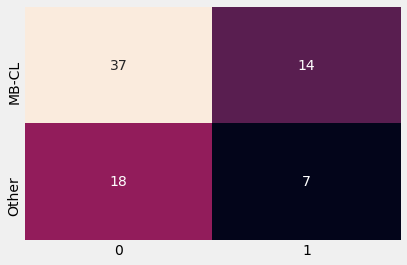

In [96]:
from sklearn import cluster
#spectral = cluster.SpectralClustering(n_clusters=2,
#                                          eigen_solver='arpack',
#                                          affinity="nearest_neighbors")
#spectral = spectral.fit(std_X_var)
#spectral
#
#cm_X=contingencymatrix(y['class'], spectral.labels)
#sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
#         yticklabels=['MB-CL','Other'])
#plt.show()

##affinity_propagation = cluster.AffinityPropagation(damping=.9,
##                                                       preference=-50)
##affinity_propagation = affinity_propagation.fit(std_X_var)
##affinity_propagation
##cm_X=contingency_matrix(y['class'], affinitypropagation.labels)
##sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
##         yticklabels=['MB-CL','Other'])
##plt.show()

meanshift= cluster.MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=1)
meanshift= meanshift.fit(std_X_var)
cm_X=contingency_matrix(y['class'], meanshift.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
         yticklabels=['MB-CL','Other'])
plt.show()

## 8. Conclusions

Draw some conclusions about this project work. Can you highlight some insights about meduloblastoma types? 

In [ ]:
# Write code in cells like this ...

Write text in cells like this...